In [1]:
#importing the required packages
import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend
import argparse
import random
import cv2
import glob

C:\Users\NiranjanKumar\Anaconda3\envs\deep\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [3]:
dataset_path = "Data\\gender_dataset_face"

In [4]:
# initial parameters
epochs = 100
lr_rate = 1e-3
batch_size = 64
img_dims = (96,96,3)
drop_out = 0.15

data = []
labels = []

In [5]:
# load image files from the dataset
random.seed(42)
image_files = [f for f in glob.glob(dataset_path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [6]:
# create groud-truth label from the image path
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

In [7]:
len(data)

10218

In [8]:
len(labels)

10218

In [9]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [10]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, 
                         width_shift_range=0.1,
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [11]:
print("training x length: ", len(trainX))
print("testing x length: ", len(testY))

training x length:  8174
testing x length:  2044


### CNN

In [12]:
#Creating a function for saving the model at each epoch end
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_id = 0
        self.losses = ''
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses += "Epoch {}: accuracy -> {:.3f}, val_accuracy -> {:.3f}\n"\
            .format(str(self.epoch_id), logs.get('acc'), logs.get('val_acc'))
        self.epoch_id += 1
 
    def on_train_begin(self, logs={}):
        self.losses += 'Training begins...\n'

In [13]:
#Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath=os.path.join('Detection\\Models', 'scratchmodel_gender2.hdf5'), 
                               verbose=1,save_best_only=True)

In [14]:
# Initialising the CNN
model = Sequential()

In [15]:
model.add(Conv2D(32, (3,3), padding="same", input_shape=(img_dims)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(drop_out))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(drop_out))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(drop_out))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation("sigmoid"))

In [16]:
#compiling
optimizer = Adam(lr=lr_rate, decay= lr_rate/epochs)
metrics=['accuracy']
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

In [17]:
# Create a loss history
history = LossHistory()

In [18]:
# train the model
x = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, 
                        verbose=1, 
                        workers = 6, 
                        callbacks = [history, checkpointer], 
                        max_q_size = 100)

C:\Users\NiranjanKumar\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., steps_per_epoch=127, max_queue_size=100, epochs=100, verbose=1, workers=6, validation_data=(array([[[...)`
  if __name__ == '__main__':


Epoch 1/100
127/127 [==============================] - 34s 266ms/step - loss: 0.5310 - acc: 0.7859 - val_loss: 0.3081 - val_acc: 0.8664

Epoch 00001: val_loss improved from inf to 0.30813, saving model to Detection\Models\scratchmodel_gender2.hdf5
Epoch 2/100
127/127 [==============================] - 13s 103ms/step - loss: 0.3899 - acc: 0.8313 - val_loss: 0.2794 - val_acc: 0.8877

Epoch 00002: val_loss improved from 0.30813 to 0.27940, saving model to Detection\Models\scratchmodel_gender2.hdf5
Epoch 3/100
127/127 [==============================] - 13s 103ms/step - loss: 0.3394 - acc: 0.8574 - val_loss: 0.2939 - val_acc: 0.8855

Epoch 00003: val_loss did not improve from 0.27940
Epoch 4/100
127/127 [==============================] - 13s 104ms/step - loss: 0.2892 - acc: 0.8796 - val_loss: 0.2212 - val_acc: 0.9188

Epoch 00004: val_loss improved from 0.27940 to 0.22121, saving model to Detection\Models\scratchmodel_gender2.hdf5
Epoch 5/100
127/127 [==============================] - 13s 1

127/127 [==============================] - 13s 105ms/step - loss: 0.0785 - acc: 0.9711 - val_loss: 0.1086 - val_acc: 0.9697- acc: 

Epoch 00041: val_loss did not improve from 0.09782
Epoch 42/100
127/127 [==============================] - 13s 104ms/step - loss: 0.0860 - acc: 0.9694 - val_loss: 0.1097 - val_acc: 0.9638

Epoch 00042: val_loss did not improve from 0.09782
Epoch 43/100
127/127 [==============================] - 13s 105ms/step - loss: 0.0809 - acc: 0.9724 - val_loss: 0.1168 - val_acc: 0.9599

Epoch 00043: val_loss did not improve from 0.09782
Epoch 44/100
127/127 [==============================] - 13s 104ms/step - loss: 0.0722 - acc: 0.9739 - val_loss: 0.1288 - val_acc: 0.9547

Epoch 00044: val_loss did not improve from 0.09782
Epoch 45/100
127/127 [==============================] - 13s 106ms/step - loss: 0.0752 - acc: 0.9723 - val_loss: 0.1049 - val_acc: 0.9662

Epoch 00045: val_loss did not improve from 0.09782
Epoch 46/100
127/127 [==============================] - 13s 1

127/127 [==============================] - 13s 106ms/step - loss: 0.0516 - acc: 0.9836 - val_loss: 0.1073 - val_acc: 0.9706

Epoch 00083: val_loss did not improve from 0.09420
Epoch 84/100
127/127 [==============================] - 13s 106ms/step - loss: 0.0473 - acc: 0.9836 - val_loss: 0.1796 - val_acc: 0.9440

Epoch 00084: val_loss did not improve from 0.09420
Epoch 85/100
127/127 [==============================] - 13s 106ms/step - loss: 0.0354 - acc: 0.9873 - val_loss: 0.1240 - val_acc: 0.9667

Epoch 00085: val_loss did not improve from 0.09420
Epoch 86/100
127/127 [==============================] - 13s 105ms/step - loss: 0.0464 - acc: 0.9849 - val_loss: 0.2396 - val_acc: 0.9450

Epoch 00086: val_loss did not improve from 0.09420
Epoch 87/100
127/127 [==============================] - 14s 106ms/step - loss: 0.0445 - acc: 0.9852 - val_loss: 0.1643 - val_acc: 0.9516

Epoch 00087: val_loss did not improve from 0.09420
Epoch 88/100
127/127 [==============================] - 14s 107ms/st

In [19]:
x.history.keys()

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])

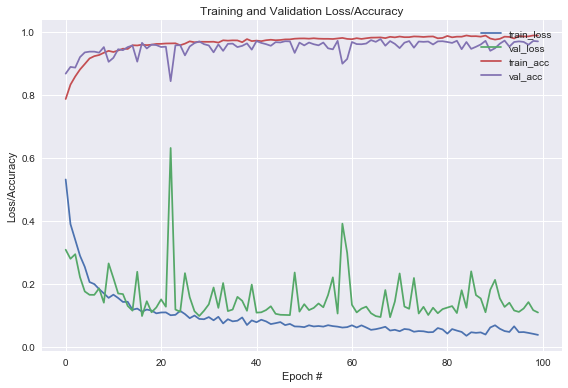

In [26]:
# plot training/validation loss/accuracy
plt.style.use("seaborn")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), x.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), x.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), x.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), x.history["val_acc"], label="val_acc")

plt.title("Training and Validation Loss/Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

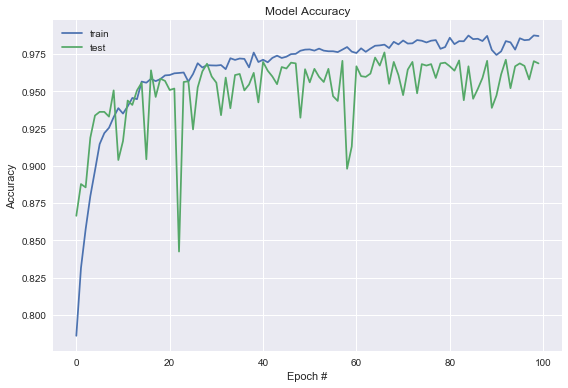

In [25]:
# summarize history for accuracy
plt.plot(x.history['acc'])
plt.plot(x.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

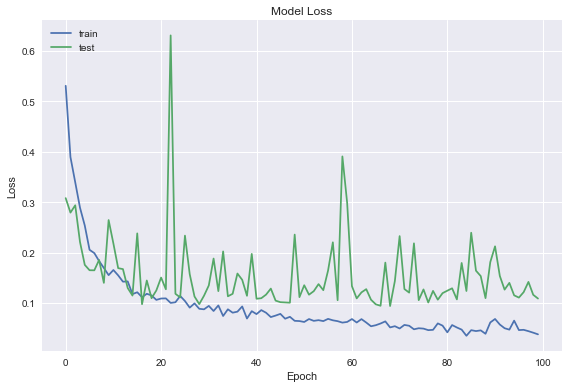

In [27]:
# summarize history for loss
plt.plot(x.history['loss'])
plt.plot(x.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
score = model.evaluate(testX, testY)
print("Accuracy on test data:", score[1])

2044/2044 [==============================] - 2s 806us/step
Accuracy on test data: 0.9686888456344604


In [29]:
# Save loss history to file
loss_history_path = os.path.join('Detection\\Models', 'scratchmodel_gender2.log')
myFile = open(loss_history_path, 'w+')
myFile.write(history.losses)
myFile.close()

In [30]:
backend.clear_session()